In [1]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/small_model.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import scipy.stats

from analysis import load_events, filter_events
import glob 


In [2]:
events_path = max(glob.glob("../../data/2024-12-04_22-41-02-arena-for-sampling-ratio-one-v-two-self-play-generated/logs_*.txt"))
print(events_path)
events = load_events(events_path)

../../data/2024-12-04_22-41-02-arena-for-sampling-ratio-one-v-two-self-play-generated/logs_2024-12-04_22-53-30_048176.txt
Start time: 1733380891.009899


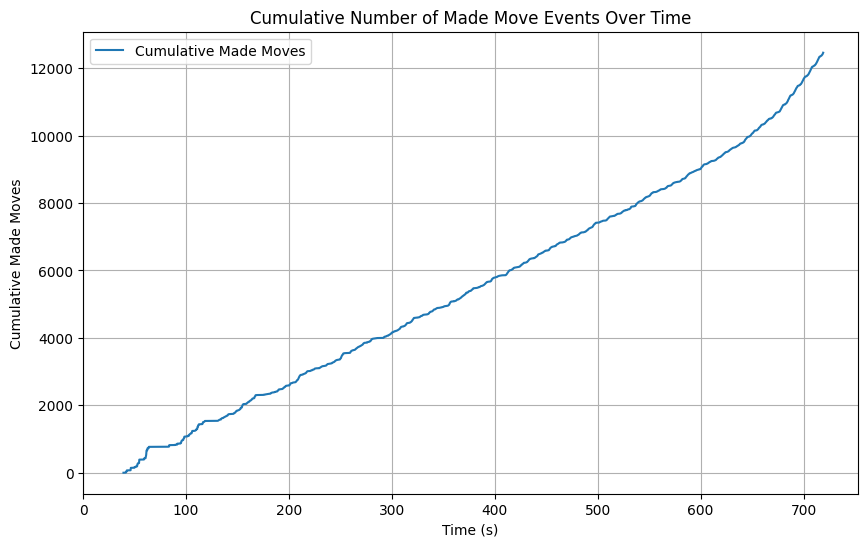

Time to first move: 39.18412113189697


In [3]:
timestamps = [event[0] for event in events if event[1] == "made_move"]
cumulative_made_moves = list(range(1, len(timestamps) + 1))

plt.figure(figsize=(10, 6))
plt.plot(timestamps, cumulative_made_moves, label='Cumulative Made Moves')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Made Moves')
plt.title('Cumulative Number of Made Move Events Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()

print(f"Time to first move: {min(timestamps)}")

In [33]:
print("Number of moves", max(cumulative_made_moves))

Number of moves 849620


In [34]:
# What percent of time is the GPU thread being used?

total_duration = 0
total_evaluated = 0
for event in events:
    if event[1] == "gpu_evaluation":
        total_duration += event[2]["duration"]
        total_evaluated += event[2]["batch_size"]

evaluations = [event[0] for event in events if event[1] == "gpu_evaluation"]
print("percent GPU utilization:", total_duration / (max(evaluations) - min(evaluations)))

percent GPU utilization: 0.8269447620280375


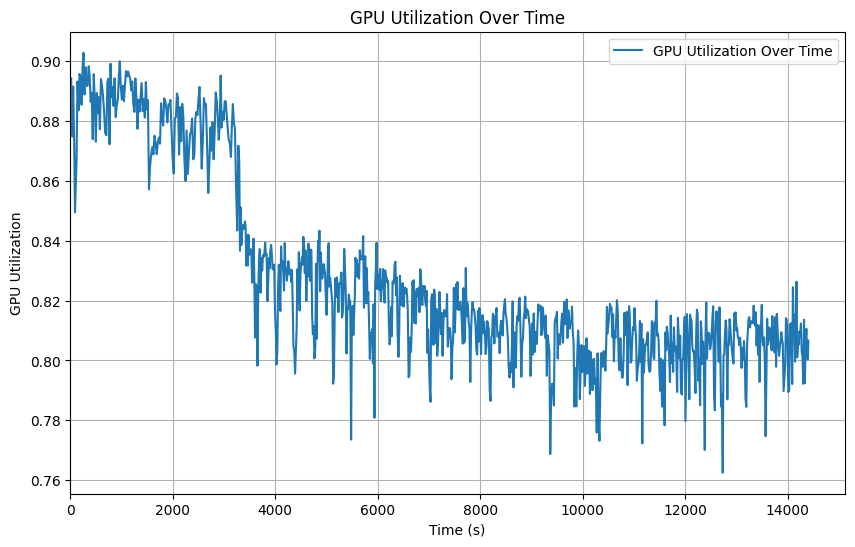

In [54]:
evaluations = [event for event in events if event[1] == "gpu_evaluation"]

gpu_utilization = []
times = []

window_size = 1000

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    time_interval = evaluations_in_window[-1][0] - evaluations_in_window[0][0]
    duration = sum(event[2]["duration"] for event in evaluations_in_window)

    gpu_utilization.append(duration / time_interval)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.plot(times, gpu_utilization, label='GPU Utilization Over Time')
plt.xlabel('Time (s)')
plt.ylabel('GPU Utilization')
plt.title('GPU Utilization Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()


/var/folders/np/v76cnj490z525wk67wqh68dc0000gn/T/ipykernel_43620/532304626.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


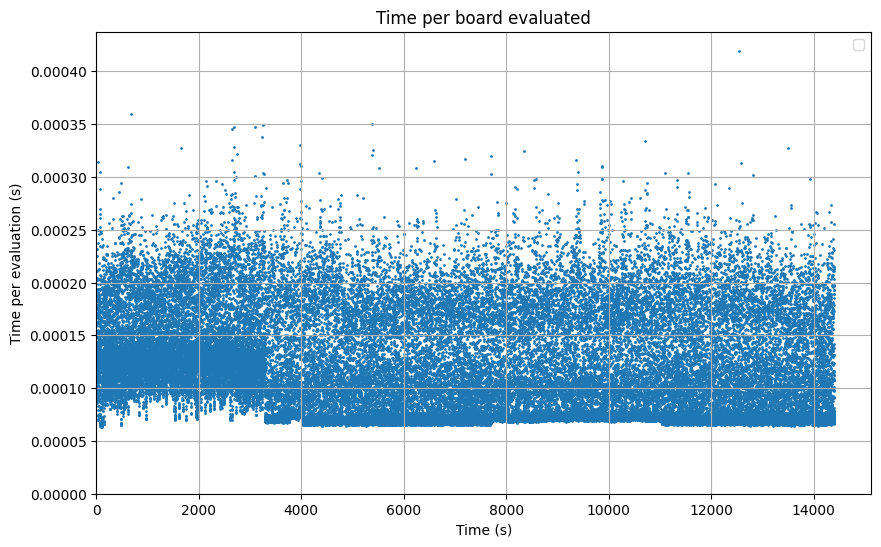

In [36]:
evaluations = [event for event in events if event[1] == "gpu_evaluation"]

time_per_evaluation = []
times = []

window_size = 10

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    duration = sum(event[2]["duration"] for event in evaluations_in_window)
    total_evaluations = sum(event[2]["batch_size"] for event in evaluations_in_window)

    time_per_evaluation.append(duration / total_evaluations)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.scatter(times, time_per_evaluation, s=1)
plt.xlabel('Time (s)')
plt.ylabel('Time per evaluation (s)')
plt.title('Time per board evaluated')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()


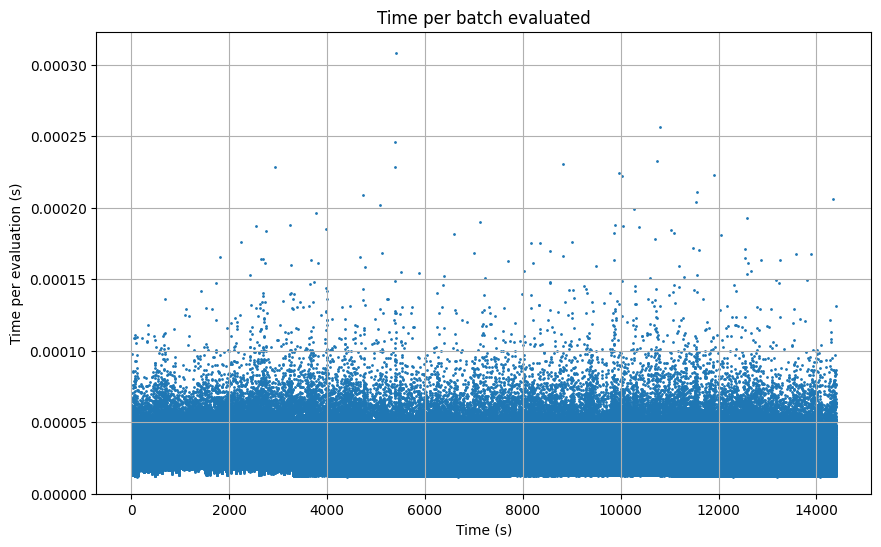

In [37]:
evaluations = [
    event for event in events if (
        event[1] == "gpu_evaluation"
        # and event[0] > 39650
        # and event[0] < 38125
    )
]

time_per_evaluation = []
times = []

window_size = 1

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    duration = sum(event[2]["duration"] for event in evaluations_in_window)
    number_of_evaluations = len(evaluations_in_window)

    time_per_evaluation.append(duration / total_evaluations)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.scatter(times, time_per_evaluation, s=1)
plt.xlabel('Time (s)')
plt.ylabel('Time per evaluation (s)')
plt.title('Time per batch evaluated')
plt.grid(True)
# plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()


In [38]:
# What is the average batch size?

batch_sizes = [event[2]["batch_size"] for event in events if event[1] == "gpu_evaluation"]
sum(batch_sizes) / len(batch_sizes)

128.0

Slope: 2.9434512105741253
Intercept: -2592.9046131080904
R-squared: 0.9986521314251736


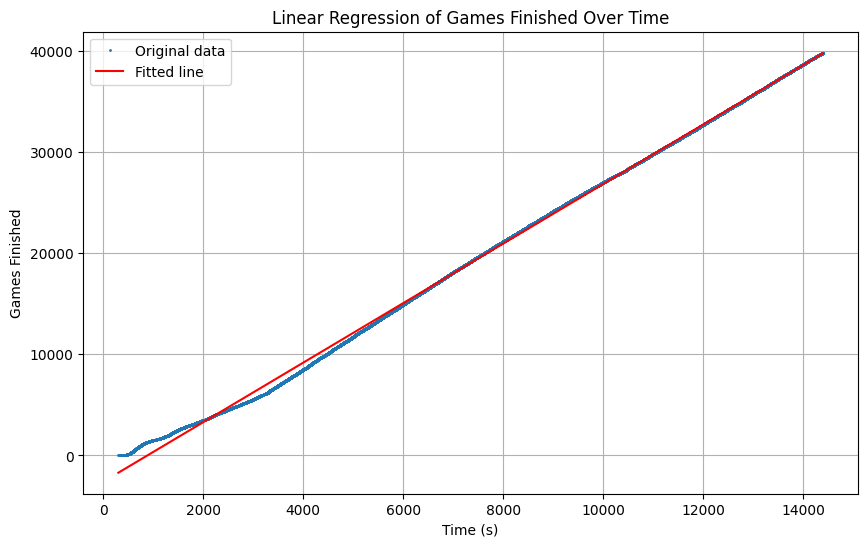

In [39]:
# Prepare the data for linear regression
x = [event[0] for event in events if event[1] == "game_end"]
y = range(len(x))

# Perform linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Original data', markersize=1)  # Made the dots smaller by reducing markersize
plt.plot(x, [slope * xi + intercept for xi in x], 'r', label='Fitted line')
plt.xlabel('Time (s)')
plt.ylabel('Games Finished')
plt.title('Linear Regression of Games Finished Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
training_events = [event for event in events if event.name.startswith("training_")]

timestamp = []
training_status = []

current_training_status = False
current_event_index = 0
for i in range(int(max([e.timestamp for e in training_events]))):
    timestamp.append(i)
    training_status.append(current_training_status)

    while training_events[current_event_index].timestamp < i:
        current_training_status = not (training_events[current_event_index - 1].name == "training_skip")
        current_event_index += 1

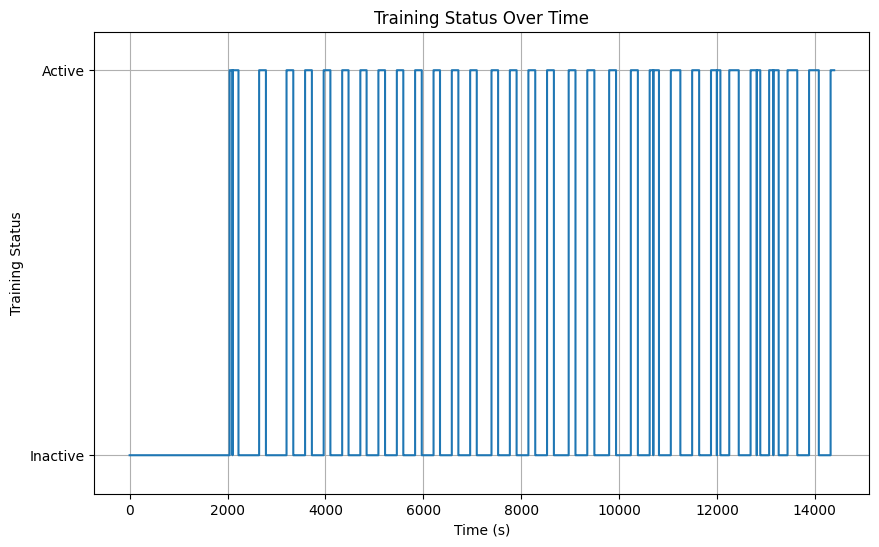

In [49]:
plt.figure(figsize=(10, 6))
plt.step(timestamp, training_status, where='post')  # Use step plot for boolean data
plt.ylim(-0.1, 1.1)  # Add padding and limit y-axis to boolean range
plt.yticks([0, 1], ['Inactive', 'Active'])  # Label the y-axis with meaningful text
plt.xlabel('Time (s)')
plt.ylabel('Training Status')
plt.title('Training Status Over Time')
plt.grid(True)
plt.show()



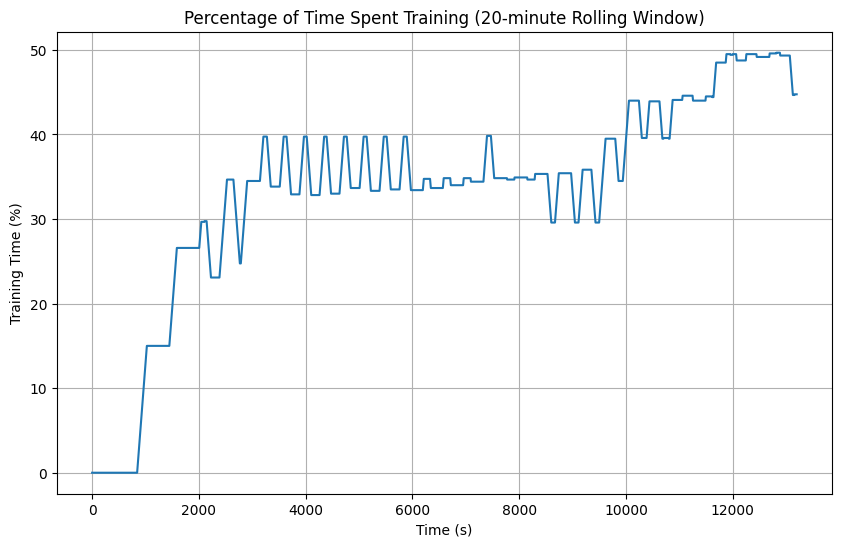

In [52]:
# Calculate percentage of time spent training in 5-minute rolling windows
window_size = 20 * 60  # 20 minutes in seconds
rolling_training_percentage = []
rolling_timestamps = []

for i in range(0, len(timestamp) - window_size):
    window = training_status[i:i + window_size]
    percentage = sum(window) / len(window) * 100
    rolling_training_percentage.append(percentage)
    rolling_timestamps.append(timestamp[i])

plt.figure(figsize=(10, 6))
plt.plot(rolling_timestamps, rolling_training_percentage)
plt.xlabel('Time (s)')
plt.ylabel('Training Time (%)')
plt.title('Percentage of Time Spent Training (20-minute Rolling Window)')
plt.grid(True)
plt.show()


In [41]:
for training_event in training_events:
    print(training_event)

Event(timestamp=0.5458340644836426, name='training_feeding_window', params={'latest_model_sample_count': 0, 'minimum_window_size': 10000, 'amount_to_feed': 10000})
Event(timestamp=2041.0339362621307, name='training_window_fed', params={})
Event(timestamp=2041.0342600345612, name='training_skip', params={})
Event(timestamp=2101.6971142292023, name='training_batch', params={'value_loss': 1.402745246887207, 'policy_loss': 1.3937057256698608, 'loss': 2.7964510917663574, 'batch_size': 64, 'cumulative_window_fed': 10032, 'ingestion_count': 32})
Event(timestamp=2102.1163301467896, name='training_batch', params={'value_loss': 1.5024826526641846, 'policy_loss': 1.2888579368591309, 'loss': 2.7913405895233154, 'batch_size': 64, 'cumulative_window_fed': 10064, 'ingestion_count': 32})
Event(timestamp=2102.523638010025, name='training_batch', params={'value_loss': 1.4176180362701416, 'policy_loss': 1.2804802656173706, 'loss': 2.6980981826782227, 'batch_size': 64, 'cumulative_window_fed': 10096, 'ing